In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from numba import jit
from scipy.special import erf
import timeit

In [ ]:
## Gain as a "function of gains"

In [ ]:
## (Pon-Poff)/(Ton-Toff) ratios where Pon and Poff are realizations. 
## Ton is (1+ 1/b^2) and Toff is (1/b^2). Thus, Ton - Toff gives 1.

In [2]:
## Defining Quantizer function with scaling; lines of code written by WT:
@jit
def quantizer_WT(a, scaling=None, nbits=8):
    # a assumed to be signal in 'lsb's' but continuous
    nlevels = 2**nbits
    max_high = nlevels/2 - 1
    max_low = -1.0*nlevels/2
    #do easy but imperfect scaling to have std be nbits/2
    desired_rms = 2**(nbits/2)
    if scaling==None:
        scaling1 = desired_rms/a.std()
    elif type(scaling)==np.float64:
        scaling1=scaling
    quantized_a_real = np.round((a.real)*scaling1,0)
    high_mask = (quantized_a_real > max_high)
    quantized_a_real[high_mask] = max_high
    low_mask = (quantized_a_real < max_low)
    quantized_a_real[low_mask] = max_low
    quantized_a_imag = np.round((a.imag)*scaling1,0)
    high_mask = (quantized_a_imag > max_high)
    quantized_a_imag[high_mask] = max_high
    low_mask = (quantized_a_imag < max_low)
    quantized_a_imag[low_mask] = max_low
    quantized_a = quantized_a_real + 1.0j*quantized_a_imag
    return quantized_a, scaling

def quantizer_WT_scaling(a, nbits=8):
    # a assumed to be signal in 'lsb's' but continuous
    nlevels = 2**nbits
    max_high = nlevels/2 - 1
    max_low = -1.0*nlevels/2
    #do easy but imperfect scaling to have std be nbits/2
    desired_rms = 2**(nbits/2)
    scaling1 = desired_rms/a.std()
    return scaling1

In [3]:
## QUANTIZATION EFFECTS!!! 
## Declaring gain array to iterate over
gains= np.arange(0.005,3.20,0.005)
## Samples corresponding to (4*42)ms; Assume each sample to be of 2.56us time bin
int_time= 4*16384
gain_auto_no_quant = []
gain_cross_no_quant = []
gain_auto_quant = []
gain_cross_quant =[]

for i, gain in enumerate(gains):
    # Defining calibration signal, noise signal (ON & OFF)
    signal = np.random.normal(0, 2**0, int_time) +1.0j*np.random.normal(0, 2**0, int_time)
    noise_term = np.random.normal(0, 2**0, int_time) +1.0j*np.random.normal(0, 2**0, int_time)
    noise_term_off = np.random.normal(0, 2**0,int_time) +1.0j*np.random.normal(0, 2**0, int_time)

    # Defining received signals
    f_signal_on = gain*signal + noise_term
    f_signal_off = noise_term_off
    # Defining scaling factors
    q_signal_scaling= np.nanmin([127.0/(6*np.std(np.real(f_signal_on))),127.0/(6*np.std(np.imag(f_signal_on)))])
    sig_scaling= np.nanmin([127.0/(6*np.std(np.real(signal))),127.0/(6*np.std(np.imag(signal)))])
    # Quantizing the signals
    q_signal_on, scaling1= quantizer_WT(f_signal_on, scaling=q_signal_scaling)
    q_signal_off, scaling2= quantizer_WT(f_signal_off, scaling=q_signal_scaling)
    q_signal, scaling3= quantizer_WT(signal, scaling=sig_scaling)
    

    # Correlation measurements w/o quantization
    auto_corr_on_no_quant = np.fft.ifft(np.fft.fft(f_signal_on[:int_time])*np.conjugate(np.fft.fft(f_signal_on[:int_time])))
    auto_corr_off_no_quant = np.fft.ifft(np.fft.fft(f_signal_off[:int_time])*np.conjugate(np.fft.fft(f_signal_off[:int_time])))
    cross_corr_on_no_quant = np.fft.ifft(np.fft.fft(f_signal_on[:int_time])*np.conjugate(np.fft.fft(signal[:int_time])))
    cross_corr_off_no_quant = np.fft.ifft(np.fft.fft(f_signal_off[:int_time])*np.conjugate(np.fft.fft(signal[:int_time])))

    # Correlation measurements w/ quantization 
    auto_corr_on_quant = np.fft.ifft(np.fft.fft(q_signal_on[:int_time])*np.conjugate(np.fft.fft(q_signal_on[:int_time])))
    auto_corr_off_quant = np.fft.ifft(np.fft.fft(q_signal_off[:int_time])*np.conjugate(np.fft.fft(q_signal_off[:int_time])))
    cross_corr_on_quant = np.fft.ifft(np.fft.fft(q_signal_on[:int_time])*np.conjugate(np.fft.fft(q_signal[:int_time]))) # TRY WITH SIGNAL
    cross_corr_off_quant = np.fft.ifft(np.fft.fft(q_signal_off[:int_time])*np.conjugate(np.fft.fft(q_signal[:int_time]))) # TRY WITH SIGNAL
 
    # Recovery of beam amplitude
    gain_auto_no_quant2 = abs(auto_corr_on_no_quant[0]) - abs(auto_corr_off_no_quant[0])
    gain_cross_no_quant2 = abs(cross_corr_on_no_quant[0]) 
    gain_auto_quant2 = (abs(auto_corr_on_quant[0])/(scaling1**2)) - (abs(auto_corr_off_quant[0])/(scaling2**2))
    gain_cross_quant2 = abs(cross_corr_on_quant[0])/(scaling1*scaling3)

    gain_auto_no_quant.append(gain_auto_no_quant2) 
    gain_cross_no_quant.append(gain_cross_no_quant2) 
    gain_auto_quant.append(gain_auto_quant2) 
    gain_cross_quant.append(gain_cross_quant2)
    # print("For gain {}, gain auto w/o quant is {}, gain cross w/o quant is {}".format(gain, gain_auto_no_quant1, gain_cross_no_quant1))

In [5]:
## converting into numpy ndarray for arithmatic operations
gain_auto_no_quant2 =np.array(gain_auto_no_quant)
gain_cross_no_quant2 = np.array(gain_cross_no_quant)
gain_auto_quant2 =np.array(gain_auto_quant)
gain_cross_quant2 = np.array(gain_cross_quant)

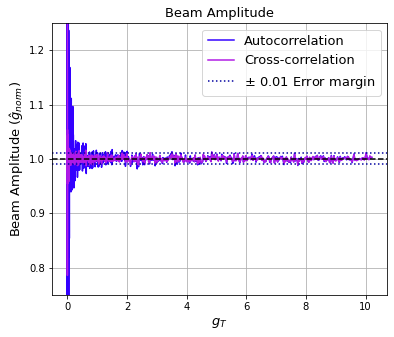

In [7]:
## Normalizing recovered gain to 1
## Normalization factor will change for quantization; done this pre-normalization operation in the previous block. 

from matplotlib import cm
import matplotlib.colors
## Importing gnuplot2 colormap
colorsarr=cm.gnuplot2(np.linspace(0,1,65))

figure(figsize= (6, 5))
plot(gains*gains, gain_auto_quant2/(2*int_time*gains*gains), label='Autocorrelation', c=colorsarr[20])
plot(gains*gains, gain_cross_quant2/(2*int_time*gains), label='Cross-correlation', c=colorsarr[30])
xlabel('$g_T$', fontsize= 13)
ylabel('Beam Amplitude ($g\u0302_{norm}$)', fontsize= 13)
title('Beam Amplitude', loc='center', fontsize= 13)
plt.grid(True)
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.axhline(y = 1.01, c=colorsarr[10], linestyle = ':', label='$\pm$ 0.01 Error margin')
plt.axhline(y = 0.99, c=colorsarr[10], linestyle = ':')
ylim(0.75,1.25)
legend(fontsize= 13)

In [ ]:
## Run it for 10000 times for int time= 4*16384 to get the mean square error/std dev of correlation measurements.
## Gain is incremented by 0.05 (instead of 0.005) to reduce run time.

gains= np.arange(0.005,3.20,0.05)
repeat=10000
int_time=4*16384
gain_auto_quant = np.zeros((repeat, len(gains)))
gain_cross_quant = np.zeros((repeat, len(gains)))

## Repeating the calculation 10000 times for each gain value
for i,gain in enumerate(gains):
  for j in np.arange(repeat):
    signal = np.random.normal(0, 2**0, int_time) +1.0j*np.random.normal(0, 2**0, int_time)
    noise_term = np.random.normal(0, 2**0, int_time) +1.0j*np.random.normal(0, 2**0, int_time)
    noise_term_off = np.random.normal(0, 2**0, int_time) +1.0j*np.random.normal(0, 2**0, int_time)
    f_signal_on = (gain*signal) + noise_term
    f_signal_off = noise_term_off

    q_signal_scaling= np.nanmin([127.0/(6*np.std(np.real(f_signal_on))),127.0/(6*np.std(np.imag(f_signal_on)))])
    sig_scaling= np.nanmin([127.0/(6*np.std(np.real(signal))),127.0/(6*np.std(np.imag(signal)))])
    q_signal_on, scaling1= quantizer_WT(f_signal_on, scaling=q_signal_scaling)
    q_signal_off, scaling2= quantizer_WT(f_signal_off, scaling=q_signal_scaling)
    q_signal, scaling3= quantizer_WT(signal, scaling= sig_scaling)
    
    auto_corr_on_quant = np.fft.ifft(np.fft.fft(q_signal_on[:int_time])*np.conjugate(np.fft.fft(q_signal_on[:int_time])))
    auto_corr_off_quant = np.fft.ifft(np.fft.fft(q_signal_off[:int_time])*np.conjugate(np.fft.fft(q_signal_off[:int_time])))
    cross_corr_on_quant = np.fft.ifft(np.fft.fft(q_signal_on[:int_time])*np.conjugate(np.fft.fft(q_signal[:int_time]))) # TRY WITH SIGNAL
    cross_corr_off_quant = np.fft.ifft(np.fft.fft(q_signal_off[:int_time])*np.conjugate(np.fft.fft(q_signal[:int_time]))) # TRY WITH SIGNAL
 
    gain_auto_quant1 = (abs(auto_corr_on_quant[0])/(scaling1**2)) - (abs(auto_corr_off_quant[0])/(scaling2**2))
    gain_cross_quant1 = abs(cross_corr_on_quant[0])/(scaling1*scaling3)

    ## Storing gain values in a matrix where each column is 10000 iterated values of given gain.
    gain_auto_quant[j,i]= gain_auto_quant1  
    gain_cross_quant[j,i]= gain_cross_quant1
    
 #   print("For gain {}, gain auto w/o quant is {}, gain cross w/o quant is {}".format(gain, gain_auto_no_quant1, gain_cross_no_quant1))

In [ ]:
gain_auto_quant_std = (gain_auto_quant/(2*int_time*gains*gains)).std(axis=0)[:len(gains)]
gain_cross_quant_std = (gain_cross_quant/(2*int_time*gains)).std(axis=0)[:len(gains)]
gain_auto_qaunt_mean= (gain_auto_quant/(2*int_time*gains*gains)).mean(axis=0)[:len(gains)]
gain_cross_quant_mean = (gain_cross_quant/(2*int_time*gains)).mean(axis=0)[:len(gains)]

In [ ]:
# Saving arrays to file 
np.savez("./ResultantArrays.npz",\
         gain_auto_quant=gain_auto_quant,\
         gain_cross_quant=gain_cross_quant,\
         gains=gains,\
         gain_auto_quant_std=gain_auto_quant_std,\
         gain_cross_quant_std=gain_cross_quant_std,\
         gain_auto_qaunt_mean=gain_auto_qaunt_mean,\
         gain_cross_quant_mean=gain_cross_quant_mean)
       
dat=np.load("./ResultantArrays.npz")
list(dat.keys())

In [ ]:
from matplotlib import cm
import matplotlib.colors
## Importing gnuplot2 colormap
colorsarr=cm.gnuplot2(np.linspace(0,1,65))

figure()
plot(gains*gains, gain_auto_quant_std, label='Autocorrelation', marker= 'o', c=colorsarr[20])
plot(gains*gains, gain_cross_quant_std, label='Cross-correlation', marker= 'o', c=colorsarr[30])
plt.axhline(y = 0.01, color = 'r', linestyle = '--')
xlabel('Input gain')
#ylabel('$\sigma_{\hat{g}10000}$ Beam Amplitude')
ylabel('Beam Amplitude Recovery')
legend()

figure()
plot(gains*gains, gain_auto_qaunt_mean, label='Autocorrelation', marker= 'o', c=colorsarr[20])
plot(gains*gains, gain_cross_quant_mean, label='Cross-correlation', marker= 'o', c=colorsarr[30])
ylim(0.99,1.01)
plt.axhline(y = 1, color = 'r', linestyle = '--')
xlabel('Input gain')
ylabel('$\mu_{\hat{g}10000}$ Beam Amplitude ')
legend()

figure()
plot(gains*gains, gain_auto_quant_std/gain_auto_qaunt_mean, label='Autocorrelation', marker= 'o', c=colorsarr[20])
plot(gains*gains, gain_cross_quant_std/gain_cross_quant_mean, label='Cross-correlation', marker= 'o', c=colorsarr[30])
plt.axhline(y = 0.01, color = 'r', linestyle = '--')
ylim(0,0.15)
xlabel('Input gain')
ylabel('$({\sigma/\mu})_{\hat{g}10000}$ Beam Amplitude')
legend()

figure()
plot(gains*gains, gain_auto_quant_std/gain_auto_qaunt_mean, label='Autocorrelation', marker= 'o', c=colorsarr[20])
plot(gains*gains, gain_cross_quant_std/gain_cross_quant_mean, label='Cross-correlation', marker= 'o', c=colorsarr[30])
plt.axhline(y = 0.01, color = 'r', linestyle = '--')
plt.axvline(x = 0.094, color = 'r', linestyle = '--')
plt.axvline(x = 0.79, color = 'r', linestyle = '--')
ylim(0.005,0.020)
xlim(0,2)
xlabel('Input gain')
#ylabel('$({\sigma/\mu})_{\hat{g}10000}$ Beam Amplitude')
ylabel('Beam Amplitude Recovery')
legend()

figure()
plot(gains*gains, (gain_auto_quant_std/gain_auto_qaunt_mean)/(gain_cross_quant_std/gain_cross_quant_mean), marker= 'o', c=colorsarr[20])
xlabel('Input gain')
ylabel('$({\sigma/\mu})_{\hat{g}10000 AUTO}/({\sigma/\mu})_{\hat{g}10000 CROSS}$')
plt.axhline(y = 1, color = 'r', linestyle = '--')
ylim(-20,20)
legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


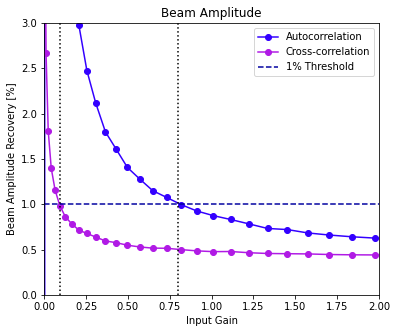

In [ ]:
from matplotlib import cm
import matplotlib.colors
## Importing gnuplot2 colormap
colorsarr=cm.gnuplot2(np.linspace(0,1,65))
#matplotlib.colors.to_rgba(colorsarr[len(gains)],alpha=1)


figure(figsize=(6,5))
plot(gains*gains, gain_auto_quant_std/gain_auto_qaunt_mean*100, label='Autocorrelation', marker= 'o', c=colorsarr[20])
plot(gains*gains, gain_cross_quant_std/gain_cross_quant_mean*100, label='Cross-correlation', marker= 'o', c=colorsarr[30])
plt.axhline(y = 1, c=colorsarr[10], linestyle = '--', label='1% Threshold')
plt.axvline(x = 0.094, color = 'black', linestyle = ':')
plt.axvline(x = 0.8, color = 'black', linestyle = ':')
ylim(0,3)
xlim(0,2)
xlabel('Input Gain', fontsize= 10)
ylabel('Beam Amplitude Recovery [%]', fontsize= 10)
title('Beam Amplitude')
legend()


In [ ]:
## Using KB's results for 10000 runs (version 1).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=np.load('/content/drive/My Drive/DigitalCalibrationSource/gain_sweep_10000.npz')
data.files
gain_auto_quant= data['gain_auto_quant']
gain_cross_quant= data['gain_cross_quant']
gains= data['gains']

In [ ]:
int_time =4*16384
gain_auto_quant_std = (gain_auto_quant/(2*int_time*gains*gains)).std(axis=0)[:len(gains)]
gain_cross_quant_std = (gain_cross_quant/(2*int_time*gains)).std(axis=0)[:len(gains)]
gain_auto_qaunt_mean= (gain_auto_quant/(2*int_time*gains*gains)).mean(axis=0)[:len(gains)]
gain_cross_quant_mean = (gain_cross_quant/(2*int_time*gains)).mean(axis=0)[:len(gains)]

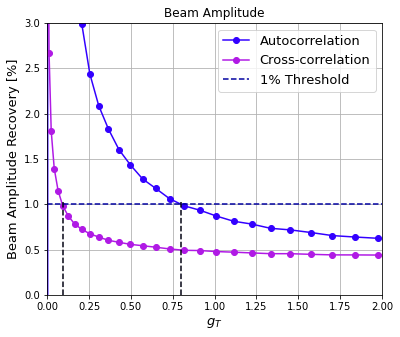

In [ ]:
## Plot of 10000 runs used for DNS paper
from matplotlib import cm
import matplotlib.colors
## Importing gnuplot2 colormap
colorsarr=cm.gnuplot2(np.linspace(0,1,65))


figure(figsize=(6,5))
plot(gains*gains, gain_auto_quant_std/gain_auto_qaunt_mean*100, label='Autocorrelation', marker= 'o', c=colorsarr[20])
plot(gains*gains, gain_cross_quant_std/gain_cross_quant_mean*100, label='Cross-correlation', marker= 'o', c=colorsarr[30])
plt.axhline(y = 1, c=colorsarr[10], linestyle = '--', label='1% Threshold')
plt.axvline(x = 0.094, c=colorsarr[1], ymin=0.0, ymax=0.35, linestyle = '--')
plt.axvline(x = 0.8, c=colorsarr[1], ymin=0.0, ymax=0.35, linestyle = '--')
plt.grid(True)
ylim(0,3)
xlim(0,2)
xlabel('$g_T$', fontsize= 13)
ylabel('Beam Amplitude Recovery [%]', fontsize= 13)
title('Beam Amplitude')
legend(fontsize= 13)

In [ ]:
## Don't run as it gives an error due to different lengths of gain arrays for both the plots 
## Can referred to as "an example for how to plot subplots":
from matplotlib import cm
import matplotlib.colors
## Importing gnuplot2 colormap
colorsarr=cm.gnuplot2(np.linspace(0,1,65))

fig,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(10,4))
ax1.plot(gains*gains, gain_auto_quant_std/gain_auto_qaunt_mean*100, label='Autocorrelation', marker= 'o', c=colorsarr[20])
ax1.plot(gains*gains, gain_cross_quant_std/gain_cross_quant_mean*100, label='Cross-correlation', marker= 'o', c=colorsarr[30])
ax1.axhline(y = 1, color = 'b', linestyle = '--', label='1% Threshold')
ax1.axvline(x = 0.094, c=colorsarr[1], linestyle = '--')
ax1.axvline(x = 0.8, c=colorsarr[1], linestyle = '--')
ax1.set_ylim(0,3)
ax1.set_xlim(0,2)
ax1.set_xlabel('Input gain')
ax1.set_ylabel('Beam Amplitude Recovery [%]')
ax1.set_title('Beam Amplitude')
ax1.legend()


ax2.plot(gains*gains, gain_auto_quant2/(2*int_time*gains*gains), label='Autocorrelation', marker= 'o', c=colorsarr[20])
ax2.plot(gains*gains, gain_cross_quant2/(2*int_time*gains), label='Cross-correlation', marker= 'o', c=colorsarr[30])
ax2.set_xlabel('Input gain', fontsize= 10)
ax2.set_ylabel('Beam amplitude ($g\u0302_{norm}$)', fontsize= 10)
ax2.set_title('Beam amplitude of the receiver as a function of its original gain', loc='center', fontsize= 10)
ax2.axhline(y = 1, color = 'r', linestyle = '--')
ax2.axhline(y = 1.01, color = 'g', linestyle = ':')
ax2.axhline(y = 0.99, color = 'g', linestyle = ':')
ax2.set_ylim(0.75,1.25)
ax2.legend()
